# Goal
The goal is to use a simple model to classify x-ray images in Keras, the notebook how to use the ```flow_from_dataframe``` to deal with messier datasets

In [201]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [202]:
all_xray_df = pd.read_csv('../input/Data_Entry_2017.csv')

In [203]:
def convert_age(age):
    try:
        if age.strip() != '':
            return int(age[:-1])
        else:
            return None
    except ValueError:
        return None
    
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].astype(str).map(convert_age).fillna(np.nan)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
36052,00009508_010.png,No Finding,10,9508,7.0,M,PA,2500,2048,0.168,0.168,NaN,../input/images_005/images/00009508_010.png
26532,00006960_003.png,No Finding,3,6960,1.0,M,PA,2048,2500,0.171,0.171,NaN,../input/images_004/images/00006960_003.png
11560,00003028_063.png,No Finding,63,3028,5.0,F,AP,2500,2048,0.168,0.168,NaN,../input/images_002/images/00003028_063.png


# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

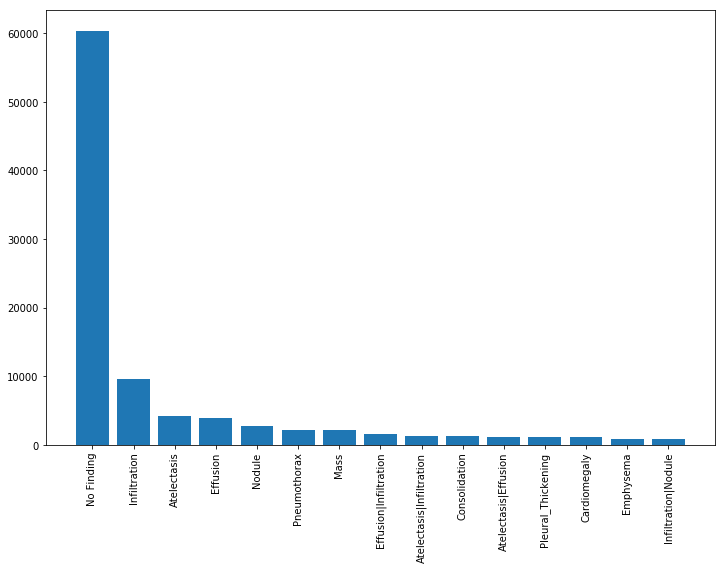

In [204]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [205]:
from itertools import chain

# Replace 'No Finding' with 'Clear' in 'Finding Labels'
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].str.replace('No Finding', 'Clear')

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Clear', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
11320,00002973_001.png,Clear,1,2973,2.0,M,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12866,00003377_005.png,Infiltration,5,3377,6.0,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
72942,00017973_000.png,Clear,0,17973,6.0,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [206]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Clear', 60361), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


I did not remove the x-rays without findings here to preserve the value of the model being able to identify cases where there is no pathology.

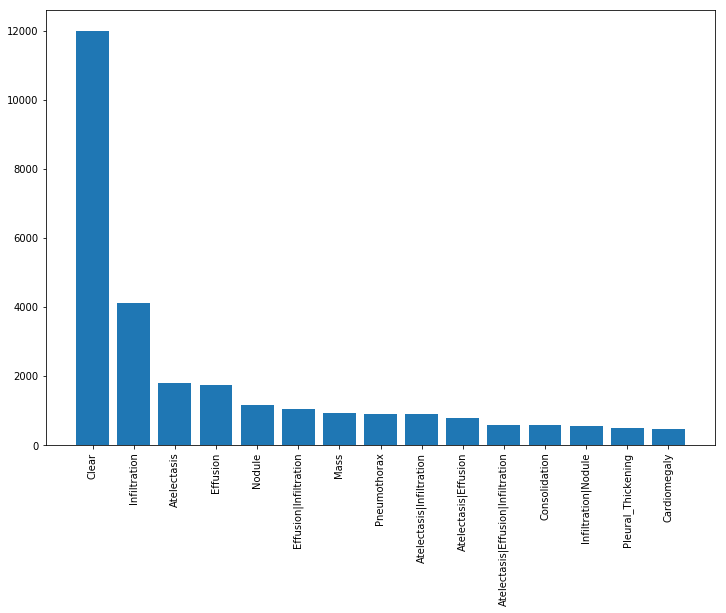

In [207]:
# Drop the "hernia" class from the dataset (case-insensitive)
all_xray_df = all_xray_df[~all_xray_df['Finding Labels'].str.contains('Hernia', case=False)]

# Calculate the weights for each sample based on the number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x) > 0 else 0).values + 4e-2

# Adjust weights for "Clear" cases to reduce their impact
clear_indices = all_xray_df['Finding Labels'].apply(lambda x: 'Clear' in x.split('|'))
sample_weights[clear_indices] *= 0.4  # Reduce the weight for "Clear" cases

# Normalize the weights to sum to 1
sample_weights /= sample_weights.sum()

# Resample the dataset with the calculated weights
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

# Visualize the distribution of finding labels in the resampled dataset
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation=90)

Reducing the dominance of the clear x-rays

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [208]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [209]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


In [210]:
# Assuming 'Finding Labels' is the column containing the labels
train_labels = train_df['Finding Labels'].values
valid_labels = valid_df['Finding Labels'].values

# You can print or explore the labels
print("Training Labels:", train_labels)
print("Validation Labels:", valid_labels)

Training Labels: ['Consolidation|Infiltration' 'Pneumothorax' 'Emphysema' ... 'Atelectasis'
 'Mass' 'Atelectasis|Pleural_Thickening']
Validation Labels: ['Mass' 'Clear' 'Atelectasis|Consolidation|Effusion|Infiltration' ...
 'Infiltration' 'Atelectasis|Effusion'
 'Atelectasis|Cardiomegaly|Effusion|Infiltration']


# Create Data Generators
Here we make the data generators for loading and randomly transforming images

In [211]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [212]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [213]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 30000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images


In [176]:
print(all_xray_df.columns)

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Atelectasis', 'Cardiomegaly', 'Clear', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax',
       'disease_vec'],
      dtype='object')


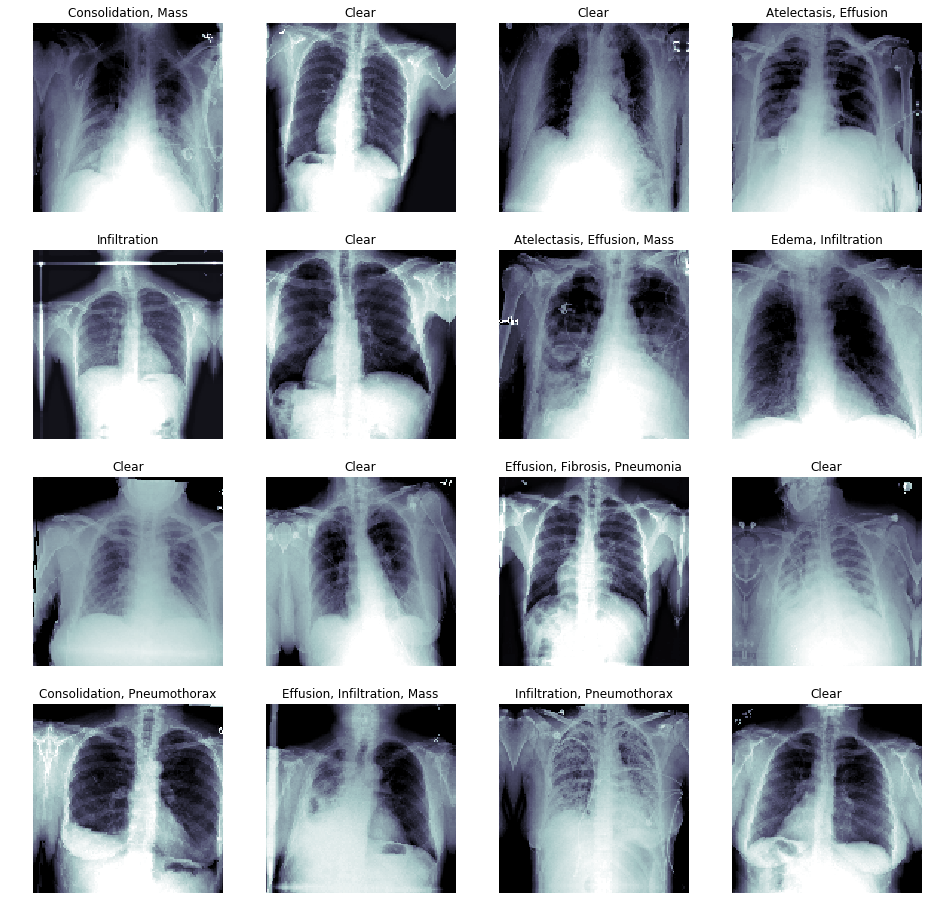

In [214]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Create a simple model
Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features

In [216]:
print(all_xray_df.columns)
print(all_labels)

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Atelectasis', 'Cardiomegaly', 'Clear', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax',
       'disease_vec'],
      dtype='object')
['Atelectasis', 'Cardiomegaly', 'Clear', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [222]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential

base_mobilenet_model = MobileNet(input_shape=t_x.shape[1:], 
                                 include_top=False, weights=None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))

# Correct the number of neurons in the last dense layer to match the number of classes (59)
multi_disease_model.add(Dense(14, activation='sigmoid'))

multi_disease_model.compile(optimizer='adam', loss='binary_crossentropy',
                            metrics=['binary_accuracy', 'mae'])
multi_disease_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_14  (None, 1024)              0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_28 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 14)                7182      
Total params: 3,760,270
Trainable params: 3,738,382
Non-trainable params: 21,888
_____________________________________________________________

In [223]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.bestv2.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

# First Round
Here we do a first round of training to get a few initial low hanging fruit results

In [224]:
print("Shape of test_Y:", test_Y.shape)


Shape of test_Y: (1024, 14)


In [225]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

Epoch 1/1
 99/100 [============================>.] - ETA: 6s - loss: 0.4309 - binary_accuracy: 0.8667 - mean_absolute_error: 0.1881 
Epoch 00001: val_loss improved from inf to 0.61661, saving model to xray_class_weights.bestv2.hdf5
100/100 [==============================] - 656s 7s/step - loss: 0.4303 - binary_accuracy: 0.8668 - mean_absolute_error: 0.1880 - val_loss: 0.6166 - val_binary_accuracy: 0.8932 - val_mean_absolute_error: 0.1350


# Check Output
Here we see how many positive examples we have of each category

In [226]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 16.41%
Cardiomegaly: 3.91%
Clear: 31.05%
Consolidation: 7.62%
Edema: 3.52%
Effusion: 21.39%
Emphysema: 3.32%
Fibrosis: 2.44%
Infiltration: 26.86%
Mass: 8.40%
Nodule: 9.67%
Pleural_Thickening: 5.96%
Pneumonia: 1.56%
Pneumothorax: 7.23%


In [227]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 53s 52ms/step


# ROC Curves
While a very oversimplified metric, we can show the ROC curve for each metric

In [228]:
import numpy as np

# Convert the arrays to numeric types if they are not already
test_Y_numeric = np.asarray(test_Y, dtype=np.float32)
pred_Y_numeric = np.asarray(pred_Y, dtype=np.float32)

# Check for NaN values
nan_indices_test_Y = np.isnan(test_Y_numeric)
nan_indices_pred_Y = np.isnan(pred_Y_numeric)

# Check for infinite values
inf_indices_test_Y = np.isinf(test_Y_numeric)
inf_indices_pred_Y = np.isinf(pred_Y_numeric)

# Find the indices where either NaN or infinite values exist
problematic_indices_test_Y = np.logical_or(nan_indices_test_Y, inf_indices_test_Y)
problematic_indices_pred_Y = np.logical_or(nan_indices_pred_Y, inf_indices_pred_Y)

# Print the indices where NaN or infinite values exist
print("Problematic indices in test_Y:", np.argwhere(problematic_indices_test_Y))
print("Problematic indices in pred_Y:", np.argwhere(problematic_indices_pred_Y))


Problematic indices in test_Y: []
Problematic indices in pred_Y: []


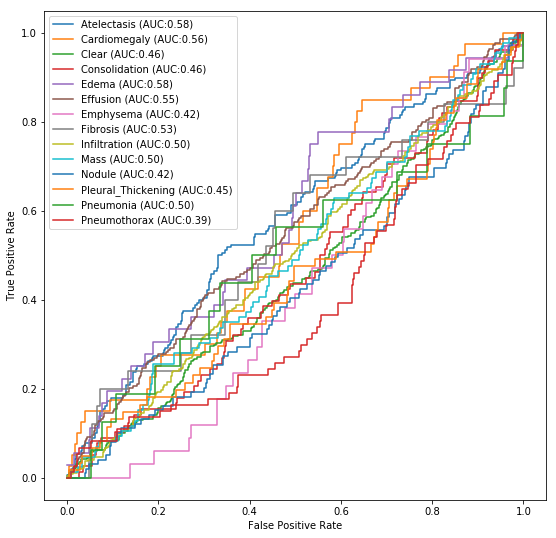

In [230]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

# Continued Training
Now we do a much longer training process to see how the results improve

In [231]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
 99/100 [============================>.] - ETA: 5s - loss: 0.3815 - binary_accuracy: 0.8791 - mean_absolute_error: 0.1831 
Epoch 00001: val_loss did not improve
100/100 [==============================] - 615s 6s/step - loss: 0.3812 - binary_accuracy: 0.8793 - mean_absolute_error: 0.1833 - val_loss: 0.6996 - val_binary_accuracy: 0.8389 - val_mean_absolute_error: 0.1581
Epoch 2/10
 99/100 [============================>.] - ETA: 5s - loss: 0.3368 - binary_accuracy: 0.8816 - mean_absolute_error: 0.1790 
Epoch 00002: val_loss improved from 0.61661 to 0.38125, saving model to xray_class_weights.bestv2.hdf5
100/100 [==============================] - 587s 6s/step - loss: 0.3368 - binary_accuracy: 0.8817 - mean_absolute_error: 0.1790 - val_loss: 0.3813 - val_binary_accuracy: 0.8328 - val_mean_absolute_error: 0.1958
Epoch 3/10
 99/100 [============================>.] - ETA: 5s - loss: 0.3218 - binary_accuracy: 0.8836 - mean_absolute_error: 0.1817 
Epoch 00003: val_loss improved from 0

In [232]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [233]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 46s 45ms/step


In [234]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 16.41%, PDx: 17.51%
Cardiomegaly: Dx: 3.91%, PDx: 2.77%
Clear: Dx: 31.05%, PDx: 36.54%
Consolidation: Dx: 7.62%, PDx: 5.48%
Edema: Dx: 3.52%, PDx: 3.49%
Effusion: Dx: 21.39%, PDx: 19.07%
Emphysema: Dx: 3.32%, PDx: 1.99%
Fibrosis: Dx: 2.44%, PDx: 1.49%
Infiltration: Dx: 26.86%, PDx: 25.25%
Mass: Dx: 8.40%, PDx: 6.82%
Nodule: Dx: 9.67%, PDx: 9.63%
Pleural_Thickening: Dx: 5.96%, PDx: 4.89%
Pneumonia: Dx: 1.56%, PDx: 1.77%
Pneumothorax: Dx: 7.23%, PDx: 4.64%


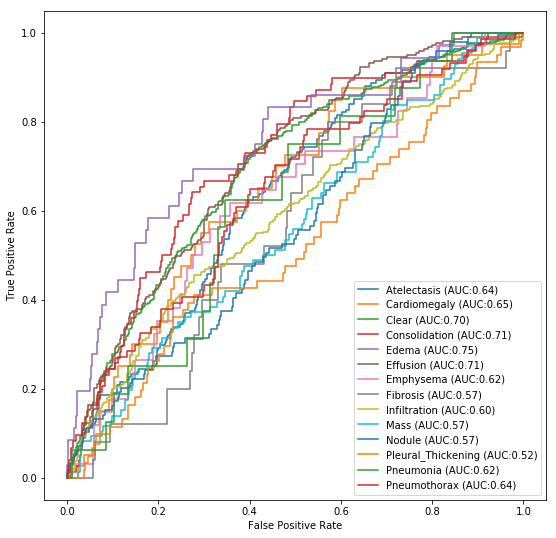

In [235]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

# Show a few images and associated predictions

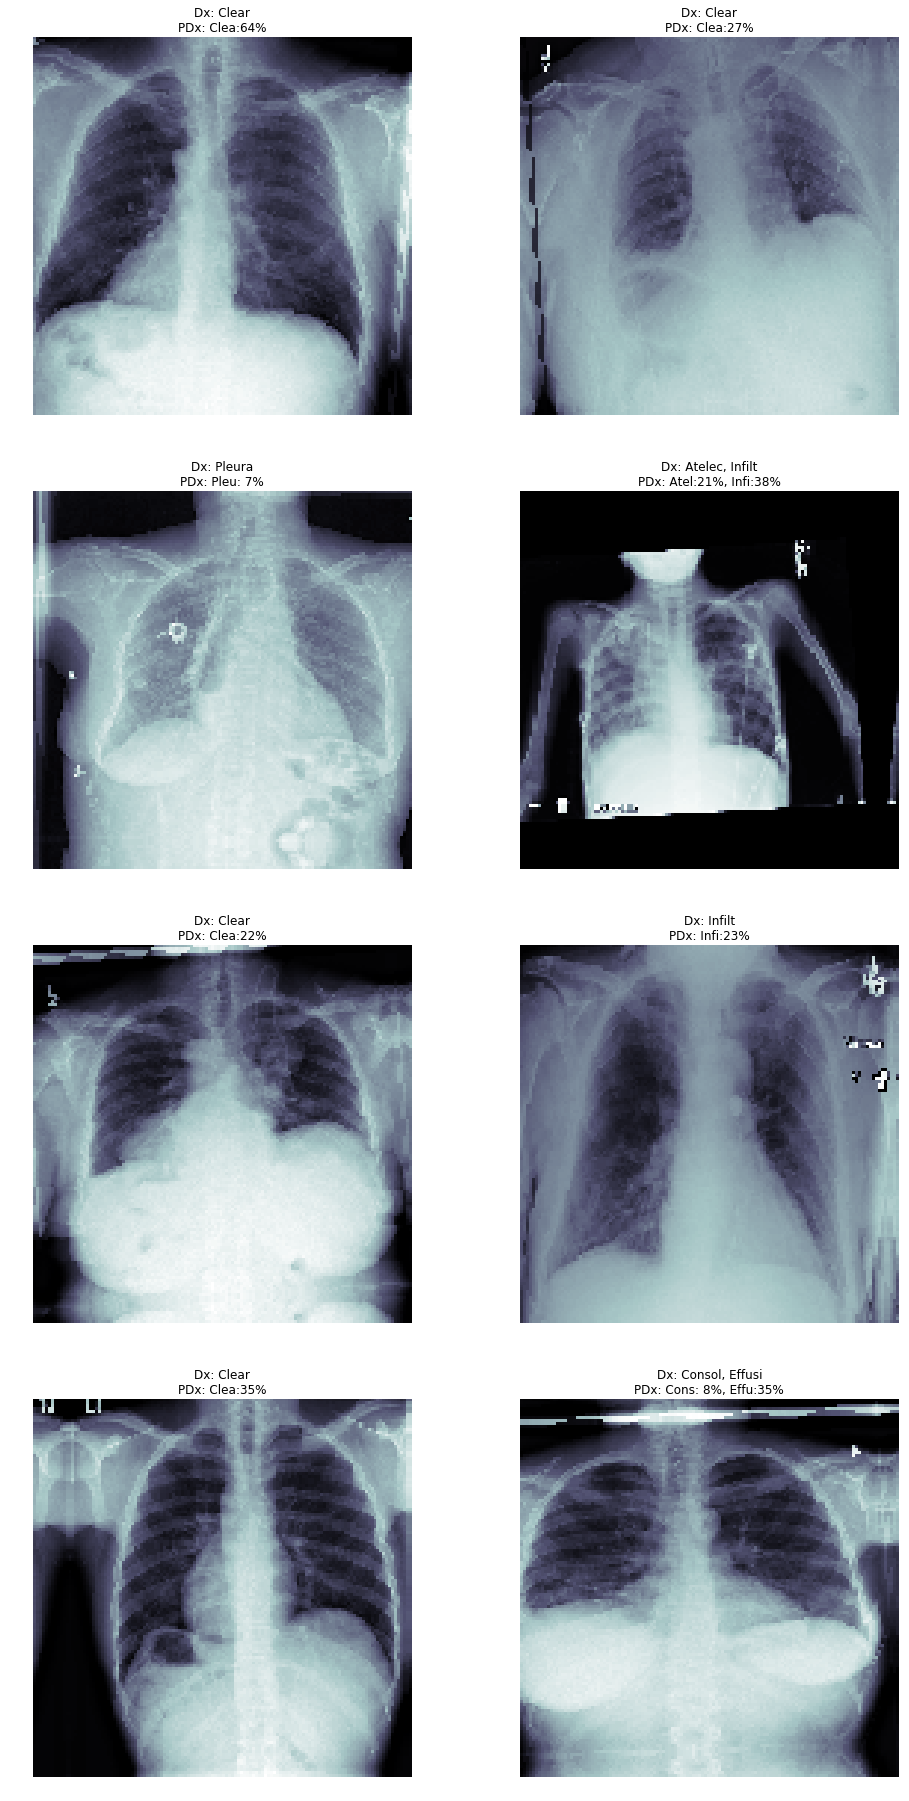

In [236]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')